In [1]:
# Exploratory ADMET Risk Analysis
# Objective:
# Explore molecular property trends associated with toxicity risk
# using public Tox21 data to support early-stage drug discovery decisions.

# Author: Manasa B
# Date: 2026


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import Descriptors


In [4]:
# Load raw Tox21 dataset
data_path = "../data/tox21_raw.csv"
df = pd.read_csv(data_path)

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (8014, 14)


,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,TOX3028,CC(O)(P(=O)(O)O)P(=O)(O)O


In [5]:
# List toxicity-related columns
tox_cols = [col for col in df.columns if col.startswith("NR-") or col.startswith("SR-")]
tox_cols


['NR-AR',
 'NR-AR-LBD',
 'NR-AhR',
 'NR-Aromatase',
 'NR-ER',
 'NR-ER-LBD',
 'NR-PPAR-gamma',
 'SR-ARE',
 'SR-ATAD5',
 'SR-HSE',
 'SR-MMP',
 'SR-p53']

In [6]:
# Select SMILES and one toxicity endpoint
df = df[['smiles', 'NR-AR']]

# Rename for clarity
df.columns = ['smiles', 'toxic']

df.head()


,smiles,toxic
0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,0.0
1,CCN1C(=O)NC(c2ccccc2)C1=O,0.0
2,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...,NaN
3,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,0.0
4,CC(O)(P(=O)(O)O)P(=O)(O)O,0.0


In [7]:
# Drop rows with missing toxicity labels
df = df.dropna(subset=['toxic']).reset_index(drop=True)

# Convert labels to int
df['toxic'] = df['toxic'].astype(int)

df['toxic'].value_counts()


toxic
0    7129
1     310
Name: count, dtype: int64

In [8]:
# Convert SMILES to RDKit molecules
df['mol'] = df['smiles'].apply(Chem.MolFromSmiles)

# Remove invalid molecules
df = df[df['mol'].notnull()].reset_index(drop=True)

print("Valid molecules:", df.shape[0])


[22:50:22] WARNING: not removing hydrogen atom without neighbors
[22:50:23] Explicit valence for atom # 3 Al, 6, is greater than permitted
[22:50:23] Explicit valence for atom # 4 Al, 6, is greater than permitted
[22:50:23] Explicit valence for atom # 4 Al, 6, is greater than permitted
[22:50:23] Explicit valence for atom # 9 Al, 6, is greater than permitted
[22:50:23] Explicit valence for atom # 5 Al, 6, is greater than permitted
[22:50:23] Explicit valence for atom # 16 Al, 6, is greater than permitted


Valid molecules: 7432


[22:50:23] Explicit valence for atom # 20 Al, 6, is greater than permitted


In [9]:
def calculate_descriptors(mol):
    return pd.Series({
        'MolWt': Descriptors.MolWt(mol),
        'LogP': Descriptors.MolLogP(mol),
        'TPSA': Descriptors.TPSA(mol),
        'HBD': Descriptors.NumHDonors(mol),
        'HBA': Descriptors.NumHAcceptors(mol),
        'RingCount': Descriptors.RingCount(mol)
    })

descriptor_df = df['mol'].apply(calculate_descriptors)

df_final = pd.concat([descriptor_df, df['toxic']], axis=1)
df_final.head()


,MolWt,LogP,TPSA,HBD,HBA,RingCount,toxic
0,258.324,1.34240,82.28,1.0,5.0,2.0,0
1,204.229,1.29940,49.41,1.0,2.0,2.0,0
2,276.424,3.75244,32.34,1.0,2.0,1.0,0
3,206.027,-0.99220,135.29,5.0,3.0,0.0,0
4,290.444,4.81720,36.92,0.0,4.0,0.0,0


In [10]:
toxic_df = df_final[df_final['toxic'] == 1]
nontoxic_df = df_final[df_final['toxic'] == 0]

print("Toxic compounds:", toxic_df.shape[0])
print("Non-toxic compounds:", nontoxic_df.shape[0])


Toxic compounds: 309
Non-toxic compounds: 7123


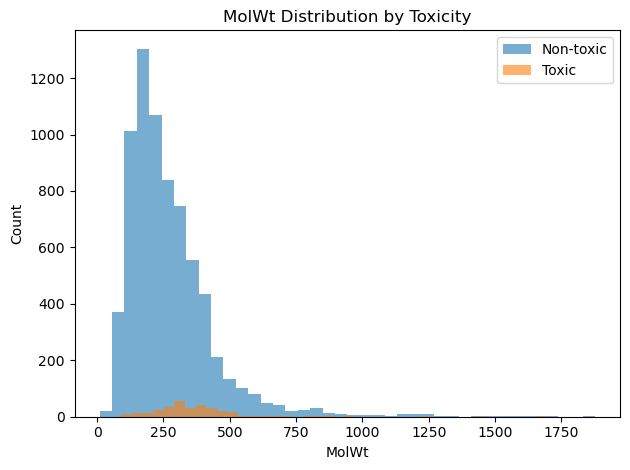

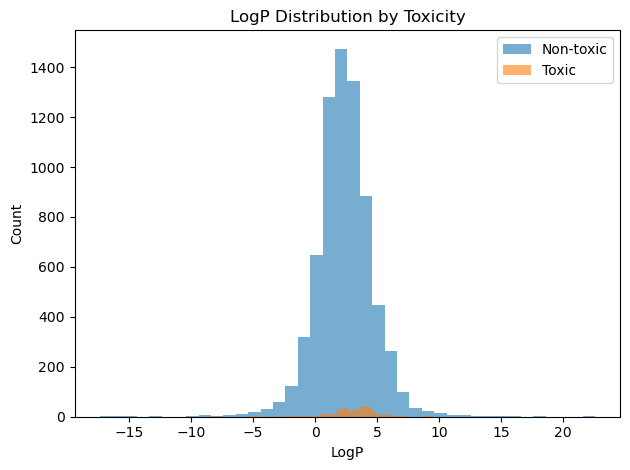

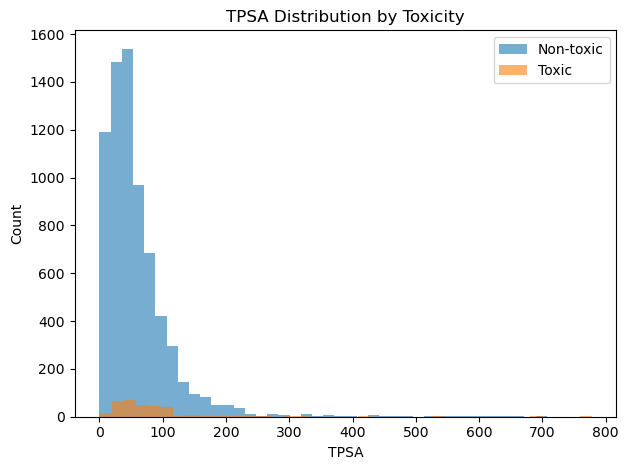

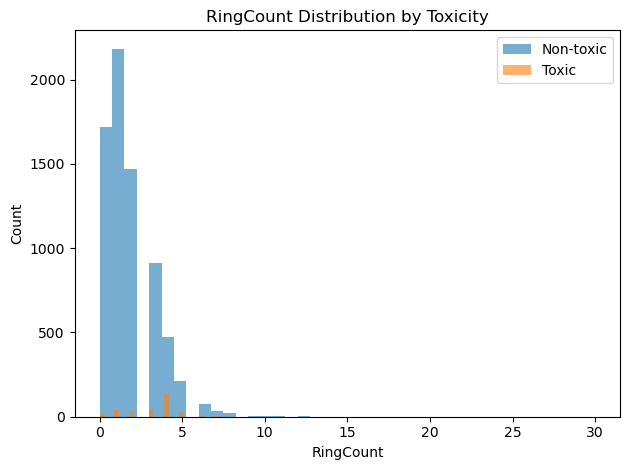

In [11]:
properties = ['MolWt', 'LogP', 'TPSA', 'RingCount']

for prop in properties:
    plt.figure()
    plt.hist(nontoxic_df[prop], bins=40, alpha=0.6, label='Non-toxic')
    plt.hist(toxic_df[prop], bins=40, alpha=0.6, label='Toxic')
    plt.xlabel(prop)
    plt.ylabel('Count')
    plt.title(f'{prop} Distribution by Toxicity')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [12]:
summary = df_final.groupby('toxic').mean()
summary


,MolWt,LogP,TPSA,HBD,HBA,RingCount
toxic,,,,,,
0,269.465224,2.354649,57.502975,1.178576,3.449109,1.677243
1,363.266042,2.951512,77.902751,1.737864,4.517799,3.294498


In [13]:
diff = summary.loc[1] - summary.loc[0]
diff.sort_values(ascending=False)


MolWt        93.800818
TPSA         20.399776
RingCount     1.617256
HBA           1.068691
LogP          0.596863
HBD           0.559288
dtype: float64

In [14]:
for prop in properties:
    plt.figure()
    plt.hist(nontoxic_df[prop], bins=40, alpha=0.6, label='Non-toxic')
    plt.hist(toxic_df[prop], bins=40, alpha=0.6, label='Toxic')
    plt.xlabel(prop)
    plt.ylabel('Count')
    plt.title(f'{prop} Distribution by Toxicity')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"../figures/{prop}_toxicity_distribution.png", dpi=300)
    plt.close()


In [15]:
def risk_flag(row):
    if (
        row['LogP'] >= 3 and
        row['RingCount'] >= 2 and
        200 <= row['MolWt'] <= 500
    ):
        return 1
    else:
        return 0

df_final['risk_flag'] = df_final.apply(risk_flag, axis=1)
df_final.head()


,MolWt,LogP,TPSA,HBD,HBA,RingCount,toxic,risk_flag
0,258.324,1.34240,82.28,1.0,5.0,2.0,0,0
1,204.229,1.29940,49.41,1.0,2.0,2.0,0,0
2,276.424,3.75244,32.34,1.0,2.0,1.0,0,0
3,206.027,-0.99220,135.29,5.0,3.0,0.0,0,0
4,290.444,4.81720,36.92,0.0,4.0,0.0,0,0


In [16]:
pd.crosstab(
    df_final['risk_flag'],
    df_final['toxic'],
    rownames=['Risk Flag'],
    colnames=['Actual Toxicity']
)


Actual Toxicity,0,1
Risk Flag,,
0,5817,176
1,1306,133


In [17]:
flagged = df_final[df_final['risk_flag'] == 1]
unflagged = df_final[df_final['risk_flag'] == 0]

print("Toxicity rate (flagged):", flagged['toxic'].mean())
print("Toxicity rate (unflagged):", unflagged['toxic'].mean())


Toxicity rate (flagged): 0.09242529534398888
Toxicity rate (unflagged): 0.029367595528116134
